In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import seaborn as sns



     

Data Loading

In [2]:
training_data = "/Users/amithajayan/Downloads/archive/Training"
testing_data  = "/Users/amithajayan/Downloads/archive/Testing"
USE_CLASS_WEIGHTS = True

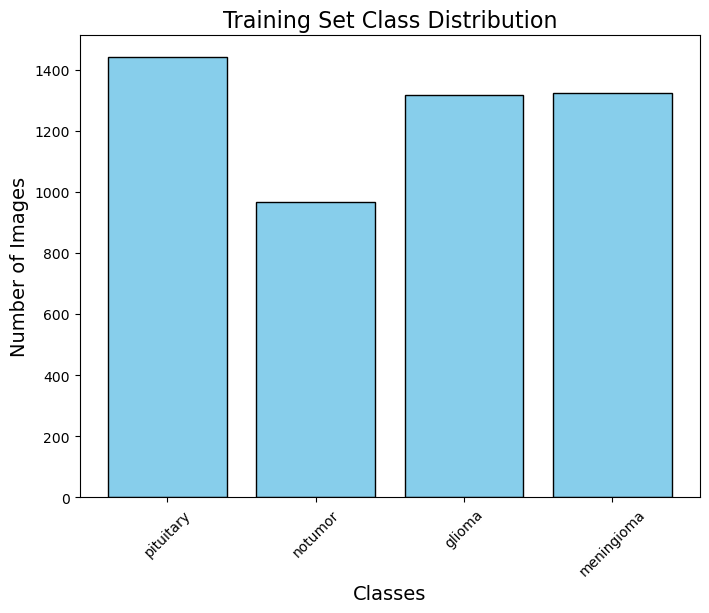

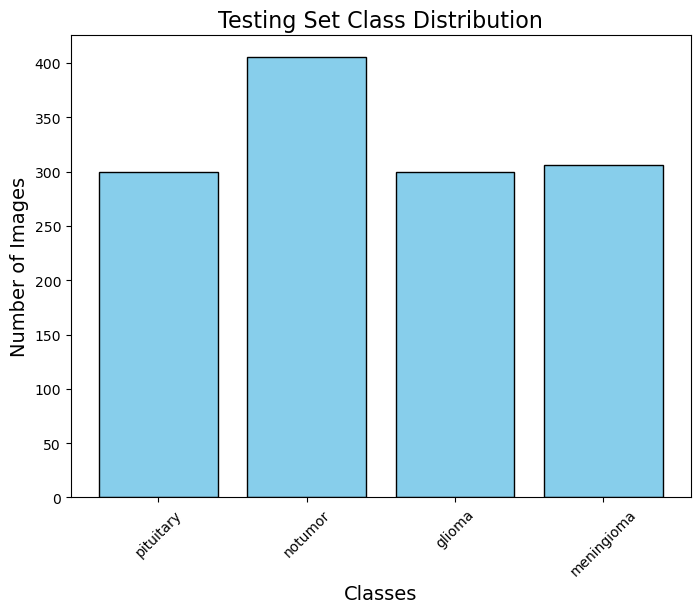

In [40]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(data_dir, title):
    # List only folders (ignore files like .DS_Store)
    classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
    counts = []
    
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        counts.append(len(os.listdir(cls_path)))
    
    plt.figure(figsize=(8,6))
    plt.bar(classes, counts, color="skyblue", edgecolor="black")
    plt.title(title, fontsize=16)
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
plot_class_distribution("/Users/amithajayan/Downloads/archive/Training", "Training Set Class Distribution")
plot_class_distribution("/Users/amithajayan/Downloads/archive/Testing", "Testing Set Class Distribution")

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_data = train_datagen.flow_from_directory(
    training_data,
    target_size = (150, 150),
    batch_size  = 12,
    class_mode  = 'categorical'
)

Found 5049 images belonging to 4 classes.


In [6]:
test_data = test_datagen.flow_from_directory(
    testing_data,
    target_size = (150, 150),
    batch_size  = 12,
    class_mode  = 'categorical'
)

Found 1311 images belonging to 4 classes.


In [7]:
train_labels = train_data.classes
if USE_CLASS_WEIGHTS:
    cls_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weight_dict = {i: w for i, w in enumerate(cls_weights)}
    print("Class weights:", class_weight_dict)
else:
    class_weight_dict = None


Class weights: {0: 0.957701062215478, 1: 0.9540816326530612, 2: 1.3039772727272727, 3: 0.8765625}


Model

In [8]:
base_model = ResNet50(include_top=False, input_shape=(150, 150, 3), weights='imagenet')
base_model.trainable = False  # <-- freezing

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

Model Compile

In [9]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train the Model

In [10]:
earlystop  = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr  = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, patience=3,
    min_lr=1e-7, verbose=1
)

Callbacks = [earlystop, reduce_lr]

history = model.fit(
    train_data,
    epochs          = 5,
    validation_data = test_data,
    class_weight    = class_weight_dict,
    callbacks       = Callbacks
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 131s 308ms/step - accuracy: 0.3615 - loss: 1.3170 - val_accuracy: 0.5072 - val_loss: 1.2057 - learning_rate: 1.0000e-04
Epoch 2/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - accuracy: 0.4734 - loss: 1.1555 - val_accuracy: 0.5317 - val_loss: 1.1820 - learning_rate: 1.0000e-04
Epoch 3/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 128s 303ms/step - accuracy: 0.5421 - loss: 1.0829 - val_accuracy: 0.5286 - val_loss: 1.1489 - learning_rate: 1.0000e-04
Epoch 4/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 134s 318ms/step - accuracy: 0.5633 - loss: 1.0420 - val_accuracy: 0.5385 - val_loss: 1.1457 - learning_rate: 1.0000e-04
Epoch 5/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 153s 364ms/step - accuracy: 0.5835 - loss: 1.0179 - val_accuracy: 0.5736 - val_loss: 1.1076 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


Plot of training

In [ ]:
import joblib

# Save model
joblib.dump(model, "model.pkl")

# Load later
loaded_model = joblib.load("model.pkl")

In [11]:
# Unfreeze the entire ResNet50 backbone
base_model.trainable = True

In [12]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_data,
    epochs          = 15,
    validation_data = test_data,
    class_weight    = class_weight_dict,
    callbacks       = Callbacks,
    verbose=1
)

Epoch 1/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.5260 - loss: 3.8059 - val_accuracy: 0.3089 - val_loss: 7.8822 - learning_rate: 1.0000e-05
Epoch 2/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.7986 - loss: 0.5626 - val_accuracy: 0.3166 - val_loss: 4.0203 - learning_rate: 1.0000e-05
Epoch 3/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 410s 974ms/step - accuracy: 0.8576 - loss: 0.3792 - val_accuracy: 0.7307 - val_loss: 0.8926 - learning_rate: 1.0000e-05
Epoch 4/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 416s 987ms/step - accuracy: 0.8930 - loss: 0.2864 - val_accuracy: 0.9260 - val_loss: 0.2107 - learning_rate: 1.0000e-05
Epoch 5/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.9178 - loss: 0.2322 - val_accuracy: 0.9542 - val_loss: 0.1469 - learning_rate: 1.0000e-05
Epoch 6/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9327 - loss: 0.1783 - val_accuracy: 0.9588 - val_loss: 0.1203 - learning_rate: 1.0000e-05
Epoch 7/15
421/421 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step

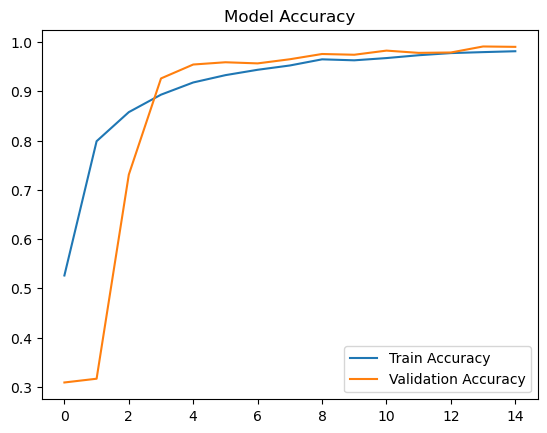

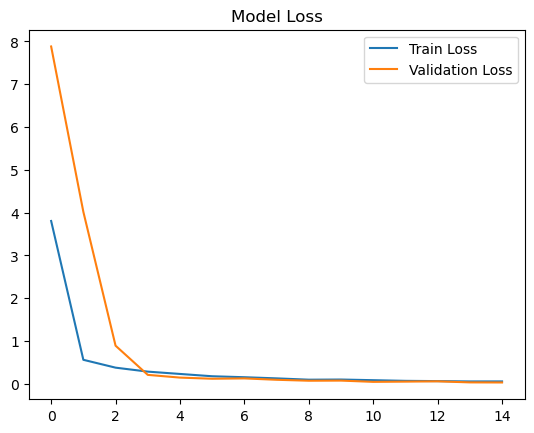

In [13]:
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.legend()
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step


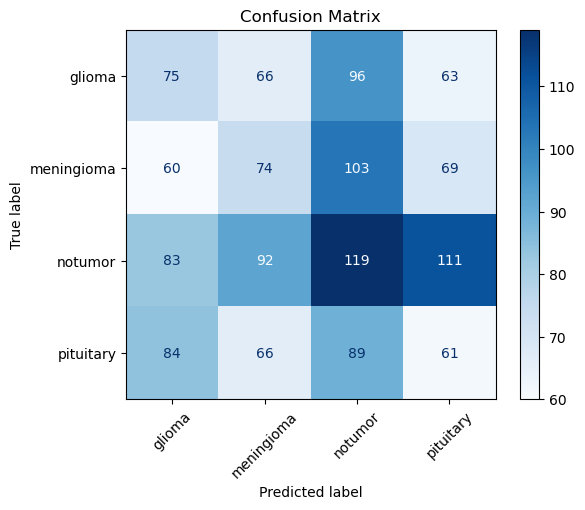

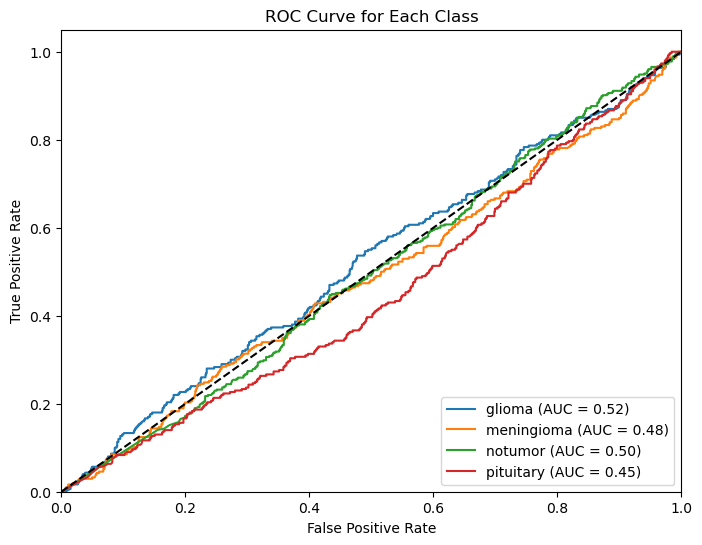

Macro AUC: 0.4875785334612238
Weighted AUC: 0.4881742798526163


In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_data)   # probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # predicted labels
y_true = test_data.classes                # true labels

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve and AUC ---
n_classes = len(test_data.class_indices)

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(test_data.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

# --- Macro & Weighted Average AUC ---
macro_auc = roc_auc_score(y_true_bin, y_pred_probs, average="macro", multi_class="ovr")
weighted_auc = roc_auc_score(y_true_bin, y_pred_probs, average="weighted", multi_class="ovr")

print("Macro AUC:", macro_auc)
print("Weighted AUC:", weighted_auc)

In [37]:
img = image.load_img("/Users/amithajayan/Downloads/pituitary2.png", target_size=(150, 150))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0) 

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
3


In [18]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9908 - loss: 0.0350

Test Accuracy: 99.08%
